#**Movies Recommendation Systems :**

#**🎯 Goal of this Project :**

- We want to answer one core question:

“Given User X, what 10 movies should we put in front of them right now to keep them watching?”

To get there, we will:

- Understand user activity and movie popularity.

Build 3 recommenders:

- Global “Top Picks for Everyone”

- “Because you watched ___”

- “Top Picks Just For You”

Evaluate them with:

- RMSE (Are our predicted ratings believable?)

- Precision@10 / Recall@10 (Are the top 10 recs actually relevant?)

Translate these results into product decisions:

- Homepage ranking

- Email / push notifications

- Promotion of new releases

#**Libraries :**

##*We :*

- Load datasets

- Remove duplicates

- Convert timestamps to datetime (if present)

- Check missing values

Why?
- Bad metadata = bad recommendations.
- If genres/categories are missing, content-based recommendations can’t work.
- If ratings are duplicated/noisy, collaborative filtering will learn the wrong signal.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt

from collections import defaultdict

pd.set_option('display.max_colwidth', 200)
sns.set(style="whitegrid")


#**Data Loading and Cleaning :**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parasharmanas/movie-recommendation-system")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'movie-recommendation-system' dataset.
Path to dataset files: /kaggle/input/movie-recommendation-system


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

movies_path  = '/content/drive/MyDrive/Uneeq_Internship/Recommendations_Dataset_Task_3/movies.csv'
ratings_path = '/content/drive/MyDrive/Uneeq_Internship/Recommendations_Dataset_Task_3/ratings.csv'

movies_df  = pd.read_csv(movies_path)
ratings_df = pd.read_csv(ratings_path)

print("Movies:", movies_df.shape)
print("Ratings:", ratings_df.shape)

display(movies_df.head())
display(ratings_df.head())

# Drop duplicates of exact same (user,movie,rating)
ratings_df = ratings_df.drop_duplicates(subset=['userId','movieId','rating'])

# Convert timestamp -> datetime if present
if 'timestamp' in ratings_df.columns:
    ratings_df['timestamp'] = pd.to_datetime(
        ratings_df['timestamp'],
        unit='s',
        errors='ignore'
    )

print("\nMissing values in movies_df:")
print(movies_df.isna().sum())

print("\nMissing values in ratings_df:")
print(ratings_df.isna().sum())


Movies: (62423, 3)
Ratings: (25000095, 4)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


/tmp/ipython-input-61092745.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  ratings_df['timestamp'] = pd.to_datetime(



Missing values in movies_df:
movieId    0
title      0
genres     0
dtype: int64

Missing values in ratings_df:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


#**✅ Data Quality Summary :**

We now have:

- A movie catalog with metadata (movies_df)

- Real user preference signals (ratings_df)

- Metadata is present .

- Ratings are clean → we can learn user taste.

We’re safe to go into profiling / EDA !

#**Data Understanding :**

Questions we answer:

- How many active users and movies are in the system?

- How many ratings in total (interactions)?

- On average, how active is a user?

- Which movies are most rated?

These matter because:

- Cold-start users: very few interactions → we need a fallback recommender.

- Cold-start items: few ratings → we need content-based recommendations.

In [5]:
n_users   = ratings_df['userId'].nunique()
n_movies  = ratings_df['movieId'].nunique()
n_ratings = len(ratings_df)

print(f" Unique users: {n_users}")
print(f" Unique movies: {n_movies}")
print(f" Total ratings: {n_ratings}")

user_activity = ratings_df.groupby('userId')['movieId'].count()
movie_popularity = ratings_df.groupby('movieId')['userId'].count()

print("\nAverage movies rated per user:", round(user_activity.mean(), 2))
print("Average ratings per movie:", round(movie_popularity.mean(), 2))

# Aggregate stats per movie
movie_stats = ratings_df.groupby('movieId').agg(
    mean_rating  = ('rating','mean'),
    rating_count = ('movieId','count')
).reset_index()

movie_stats = movie_stats.merge(movies_df, on='movieId', how='left')

movie_stats.sort_values(by='rating_count', ascending=False).head(10)


 Unique users: 162541
 Unique movies: 59047
 Total ratings: 25000095

Average movies rated per user: 153.81
Average ratings per movie: 423.39


,movieId,mean_rating,rating_count,title,genres
351,356,4.048011,81491,Forrest Gump (1994),Comedy|Drama|Romance|War
314,318,4.413576,81482,"Shawshank Redemption, The (1994)",Crime|Drama
292,296,4.188912,79672,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
585,593,4.151342,74127,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2480,2571,4.154099,72674,"Matrix, The (1999)",Action|Sci-Fi|Thriller
257,260,4.120189,68717,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
475,480,3.679175,64144,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
522,527,4.247579,60411,Schindler's List (1993),Drama|War
108,110,4.002273,59184,Braveheart (1995),Action|Drama|War
2867,2959,4.228311,58773,Fight Club (1999),Action|Crime|Drama|Thriller


#**📌 Insight for Stakeholders :**

- High rating_count movies = “Everyone watched this.”
This is perfect for a default “Trending Now” row on the homepage.

- High mean_rating but low rating_count = “cult favourites / hidden gems.”
These hook advanced users and make them feel seen → retention.

- We will explicitly use both ideas in our recommendation strategies.

#**Exploratory Data Analysis (EDA) :**

We’ll explore:

- Rating behaviour (do users give mostly high scores?)

- Most-watched movies

- Relationship between popularity and quality

This guides how we design and evaluate the recommender.

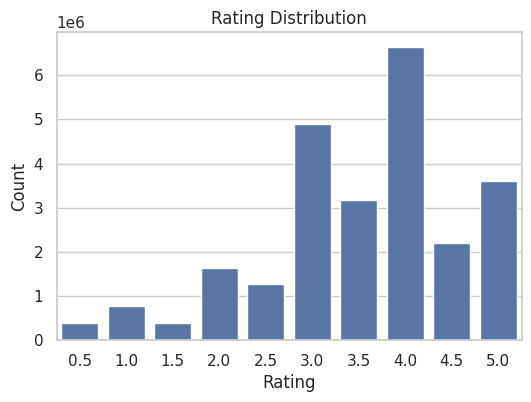

count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [6]:
# Rating Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=ratings_df['rating'])
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

print(ratings_df['rating'].describe())


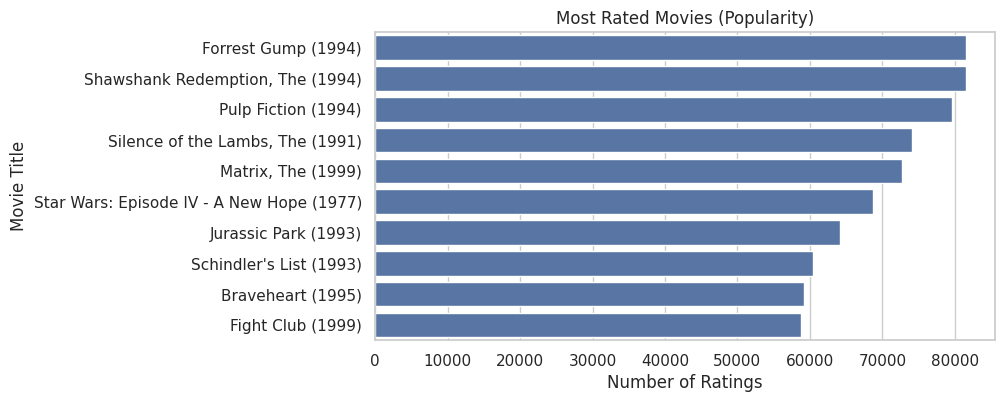

,title,rating_count,mean_rating
351,Forrest Gump (1994),81491,4.048011
314,"Shawshank Redemption, The (1994)",81482,4.413576
292,Pulp Fiction (1994),79672,4.188912
585,"Silence of the Lambs, The (1991)",74127,4.151342
2480,"Matrix, The (1999)",72674,4.154099
257,Star Wars: Episode IV - A New Hope (1977),68717,4.120189
475,Jurassic Park (1993),64144,3.679175
522,Schindler's List (1993),60411,4.247579
108,Braveheart (1995),59184,4.002273
2867,Fight Club (1999),58773,4.228311


In [7]:
# Most Popular Movies
top_popular = movie_stats.sort_values('rating_count', ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(
    y=top_popular['title'],
    x=top_popular['rating_count']
)
plt.title("Most Rated Movies (Popularity)")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()

display(top_popular[['title','rating_count','mean_rating']])


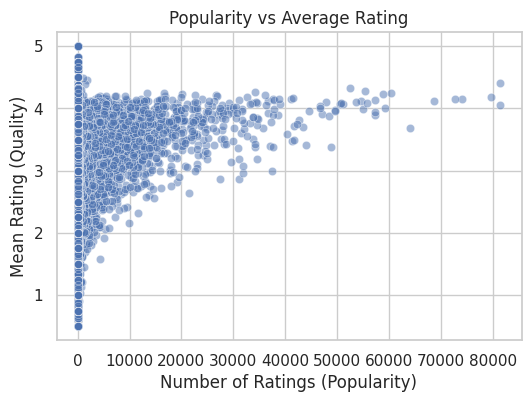

In [8]:
# Popularuty VS Quality
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=movie_stats,
    x='rating_count',
    y='mean_rating',
    alpha=0.5
)
plt.title("Popularity vs Average Rating")
plt.xlabel("Number of Ratings (Popularity)")
plt.ylabel("Mean Rating (Quality)")
plt.show()


#**🎯 EDA Conclusions :**

- Ratings are often high (e.g. median ~3-4+).
→ RMSE alone might look “good,” so we also need ranking metrics like Precision@10.

- Some movies are insanely popular even if they’re not the highest-rated.
→ These go in a “Top Picks Right Now” banner for new/inactive users.

- Some movies are niche but loved.
→ Personalised recommenders can surface these to keep power-users engaged.

- This is exactly how platforms reduce churn:
Mainstream content = acquisition.
Personal gems = retention.

#**Baseline Recommender (Global Popularity) :**

Logic:

- Rank each movie by how many times it’s been rated (rating_count).

- Break ties using mean rating.

- Recommend Top N.

This is shown to:

- Completely new users

- Logged-out visitors

- Marketing campaigns (“Trending Now !”)

In [9]:
baseline_recs = movie_stats.sort_values(
    by=['rating_count','mean_rating'],
    ascending=[False, False]
)[['movieId','title','rating_count','mean_rating']].head(10)

baseline_recs


,movieId,title,rating_count,mean_rating
351,356,Forrest Gump (1994),81491,4.048011
314,318,"Shawshank Redemption, The (1994)",81482,4.413576
292,296,Pulp Fiction (1994),79672,4.188912
585,593,"Silence of the Lambs, The (1991)",74127,4.151342
2480,2571,"Matrix, The (1999)",72674,4.154099
257,260,Star Wars: Episode IV - A New Hope (1977),68717,4.120189
475,480,Jurassic Park (1993),64144,3.679175
522,527,Schindler's List (1993),60411,4.247579
108,110,Braveheart (1995),59184,4.002273
2867,2959,Fight Club (1999),58773,4.228311


#**✅ Baseline Takeaway :**

- This is safe. It never recommends something completely random.

- BUT it’s not personal. Everyone gets the same list.

- We use this baseline to judge if our smarter models actually add value.

#**Content-Based Recommender :**

Idea:
- We recommend movies that are similar in content to a movie the user liked.

How:

- Take each movie’s genres text as a mini “description.”

- Use TF-IDF to vectorise those descriptions.

- Compute cosine similarity between all movies.

- For a given movie, return the most similar ones.

Why it matters to the business:

- Works even if a movie is brand new (cold start for items).
We just need its metadata, not lots of ratings.

- Powers “Because you watched [Movie X]” section

In [1]:
# Clean genres into space-separated tokens
movies_df['genres'] = movies_df['genres'].fillna("").str.replace('|',' ')

# TF-IDF over genres
tfidf = TfidfVectorizer(stop_words='english')
genre_matrix = tfidf.fit_transform(movies_df['genres'])  # shape: [n_movies x n_terms]

# Compute pairwise similarity
cosine_sim = cosine_similarity(genre_matrix, genre_matrix)

# Map title -> index for lookup
title_to_index = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

def similar_movies(title, n=10):
    if title not in title_to_index:
        raise ValueError(f"'{title}' not found in dataset.")

    idx = title_to_index[title]

    # similarity scores for this movie vs all
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort by similarity descending
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # skip itself (0th)
    sim_scores = sim_scores[1:n+1]

    movie_indices = [i[0] for i in sim_scores]
    return movies_df[['movieId','title','genres']].iloc[movie_indices]

# Example:
similar_movies("Toy Story (1995)", n=5)


NameError: name 'movies_df' is not defined

#**💼 Content-Based Business Use :**

- Powers “Because you watched ___”.

- Can also be used to promote new releases:
If we drop a new original sci-fi thriller, we immediately push it to users who love sci-fi thriller, even if nobody has rated it yet.

- Limitation: Only recommends similar “style.”
It doesn’t learn your weird guilty pleasures across genres.
- That’s where collaborative filtering comes in next.

#**Collaborative Filtering (Matrix Factorisation with TruncatedSVD) :**

Idea:

- If User A and User B rated a bunch of the same movies highly,
and User B also loved Movie Z,
then recommend Movie Z to User A.

- We’re not looking at genres at all here.
- We’re learning “taste vectors.”

Steps:

- Build a user-item matrix (rows = users, columns = movies, cells = ratings).

- Use TruncatedSVD to learn latent features.

- Reconstruct predicted ratings: “What would this user rate this movie?”

- Recommend the Top-N highest predicted ratings that the user hasn't seen.

In [1]:
ratings_matrix = ratings_df.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
)

# fill unrated with 0 so we can do SVD
ratings_filled = ratings_matrix.fillna(0)

ratings_matrix.shape, ratings_filled.shape


NameError: name 'ratings_df' is not defined

In [2]:
# Choose number of latent "taste" dimensions
svd = TruncatedSVD(n_components=50, random_state=42)

user_factors = svd.fit_transform(ratings_filled)  # shape: [n_users x 50]
item_factors = svd.components_                     # shape: [50 x n_movies]

# approximate ratings = U * V
pred_matrix = np.dot(user_factors, item_factors)

pred_df = pd.DataFrame(
    pred_matrix,
    index=ratings_filled.index,      # userId
    columns=ratings_filled.columns   # movieId
)

pred_df.head()


NameError: name 'TruncatedSVD' is not defined

In [ ]:
# RMSE Rating
true_vals = []
pred_vals = []

# Compare predicted vs actual on all known (user,movie) pairs
for row in ratings_df.itertuples(index=False):
    u = row.userId
    m = row.movieId
    r_true = row.rating

    if (u in pred_df.index) and (m in pred_df.columns):
        r_pred = pred_df.loc[u, m]
        true_vals.append(r_true)
        pred_vals.append(r_pred)

rmse_svd = sqrt(mean_squared_error(true_vals, pred_vals))
print("Approximate RMSE (SVD CF):", rmse_svd)


In [ ]:
# Top -N for a given user
def recommend_for_user(user_id, n=10, min_rating_threshold=3.5):
    """
    1. Get predicted ratings for this user for ALL movies.
    2. Drop movies they've already rated (don't recommend repeats).
    3. Sort by predicted rating.
    4. Return top n items with metadata.
    """
    if user_id not in pred_df.index:
        return f"User {user_id} not found."

    # predicted scores for that user
    user_scores = pred_df.loc[user_id]

    # movies already rated by this user
    seen_movies = ratings_df[ratings_df['userId']==user_id]['movieId'].unique()
    user_scores = user_scores.drop(labels=seen_movies, errors='ignore')

    # sort by predicted rating descending
    top_movies = user_scores.sort_values(ascending=False).head(n)

    recs = (
        top_movies.reset_index()
        .merge(movies_df[['movieId','title','genres']], on='movieId', how='left')
        .rename(columns={0:'predicted_rating'})
    )

    recs.columns = ['movieId','predicted_rating','title','genres']
    return recs

sample_user = ratings_df['userId'].iloc[0]
recommend_for_user(sample_user, n=10)


#**📈 CF Business Impact :**

- This is “Top Picks For You.”

- It understands cross-genre taste.
- If you like dark detective thrillers and sarcastic comedies, it will learn that combo.

- This directly drives retention: if what you see on the homepage feels tailored, you stay.

#**Recommendation Quality (Precision@10 / Recall@10) :**

Definitions (per user):

- Mark an item “relevant” if the true rating they gave it is ≥ 4.

- Get Top K highest predicted ratings for that user (unseen movies only).

- Precision@K: Of the K we recommended, how many were actually relevant?

- Recall@K: Of all the movies they actually liked, how many did we recommend?

- High Precision → user sees mostly good stuff
- High Recall → we’re not missing their favourites

In [ ]:
def precision_recall_at_k(pred_df, ratings_df, k=10, threshold=4.0):
    precisions = {}
    recalls = {}

    # loop over all users we have predictions for
    for user_id in pred_df.index:
        # all actual ratings for this user
        user_true = ratings_df[ratings_df['userId'] == user_id]

        if user_true.empty:
            continue

        # what this user TRULY liked (>= threshold)
        relevant_items = user_true[user_true['rating'] >= threshold]['movieId'].tolist()

        # predicted preference scores for that user
        user_pred_scores = pred_df.loc[user_id]

        # remove items they've already rated (we wouldn't "recommend" those again)
        already_seen = user_true['movieId'].unique()
        candidate_scores = user_pred_scores.drop(labels=already_seen, errors='ignore')

        # Top-K recommendations
        top_k_items = candidate_scores.sort_values(ascending=False).head(k).index.tolist()

        # intersection: relevant & recommended
        rel_and_rec = set(top_k_items).intersection(set(relevant_items))

        # Precision@K
        precisions[user_id] = len(rel_and_rec) / k if k > 0 else 0.0

        # Recall@K
        recalls[user_id] = (
            len(rel_and_rec) / len(relevant_items)
            if len(relevant_items) > 0
            else 0.0
        )

    mean_precision = np.mean(list(precisions.values())) if precisions else 0.0
    mean_recall    = np.mean(list(recalls.values())) if recalls else 0.0
    return mean_precision, mean_recall

p_at_10, r_at_10 = precision_recall_at_k(pred_df, ratings_df, k=10, threshold=4.0)
print("Mean Precision@10:", p_at_10)
print("Mean Recall@10:", r_at_10)


#**🎯 KPI Interpretation :**

- Precision@10 high → when we recommend 10 movies, most are genuinely relevant.
This keeps the homepage high quality and clickable.

- Recall@10 high → we’re successfully surfacing most of what they’d actually love.
This reduces “I can’t find anything to watch” frustration.

- These are literally engagement KPIs used by real product teams for recommender quality.

#**Final Recommendations & Business Impact :**
What we built:

- Baseline Popularity Model

- Ranks movies by engagement (rating_count) and average score.

- Solves the cold-start problem for new users: “Trending Now.”

- Content-Based Recommender (TF-IDF + Cosine Similarity)

- “Because you watched ___.”

- Uses metadata like genres.

- Solves cold-start for new items (we can recommend a brand-new release immediately).

- Collaborative Filtering (TruncatedSVD latent factors)

- Learns hidden preference patterns across users.

- Generates Top-N personalised recommendations for each user.

Evaluated using:

- RMSE (numerical accuracy of rating prediction)

- Precision@10 / Recall@10 (relevancy of Top 10 recs)

Why this matters:

- This pipeline can drive:

- Personalised homepage rows

- Email / push “Top picks for tonight”

- Cross-sell (“people who liked X also loved Y”)

- Strong Precision@10 and Recall@10 = higher watch time / conversion / retention.

- This is how platforms fight churn.

Next steps (real deployment roadmap):

- Hybrid Ranking:
Combine Collaborative Filtering + Content-Based to handle both user cold-start and item cold-start in one final ranked list.

- Freshness Boost:
Add a small time-based boost so new/priority titles are surfaced early (marketing spotlight).

- Diversity Control:
Penalise recommending 10 near-identical superhero sequels.
Mix in variety so the shelf doesn’t feel repetitive.

- Closed-Loop Optimisation:
Track watch duration / click-through in production → retrain regularly → continuous improvement.